In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Questão 1

### Dataset


In [2]:
# Definindo os padrões de entrada (vértices do cubo)
entradas = np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1]
]).astype(float)

# Vetores de resposta associados a cada padrão de entrada
respostas = np.array([
    [1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 1, -1, -1, -1, -1],
    [-1, -1, -1, -1, 1, -1, -1, -1],
    [-1, -1, -1, -1, -1, 1, -1, -1],
    [-1, -1, -1, -1, -1, -1, 1, -1],
    [-1, -1, -1, -1, -1, -1, -1, 1]
]).astype(float)

In [3]:
# Função para adicionar ruído já definida anteriormente
def adicionar_ruido(entradas, raio_ruido):
    entradas_ruidosas = np.copy(entradas)
    ruido = np.random.uniform(-raio_ruido, raio_ruido, entradas.shape)
    entradas_ruidosas += ruido
    return entradas_ruidosas

# Definindo o raio máximo do ruído
raio_ruido = 0.1

# Criando o conjunto de validação com ruído
conjunto_validacao = adicionar_ruido(entradas, raio_ruido)
conjunto_validacao

array([[ 0.02471852,  0.08211516,  0.0462219 ],
       [ 0.00283491, -0.04160092,  0.99252032],
       [ 0.04407801,  1.03793016, -0.03713921],
       [-0.06577794,  1.09034865,  0.98057293],
       [ 1.08552649, -0.0336995 ,  0.01301374],
       [ 0.91073295, -0.04552059,  0.91702884],
       [ 1.09687496,  0.97830764,  0.07166844],
       [ 1.04877242,  0.94042041,  0.93757316]])

In [4]:
X = entradas.T
Y = respostas.reshape((8, len(respostas)))

print ('The shape of X: ' + str(X.shape))
print ('The shape of Y: ' + str(Y.shape))
print ('I have m = %d training examples!' % (X.shape[1]))


The shape of X: (3, 8)
The shape of Y: (8, 8)
I have m = 8 training examples!


# Perceptron de Rosenblatt

In [5]:
def layer_sizes(X, Y):
    n_x = X.shape[0]  # Size of input layer
    n_y = Y.shape[0]  # Size of output layer
    return (n_x, n_y)

In [6]:
(n_x, n_y) = layer_sizes(X, Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 3
The size of the output layer is: n_y = 8


Temos 8 exemplos de treinamento, com 3 atributos cada.

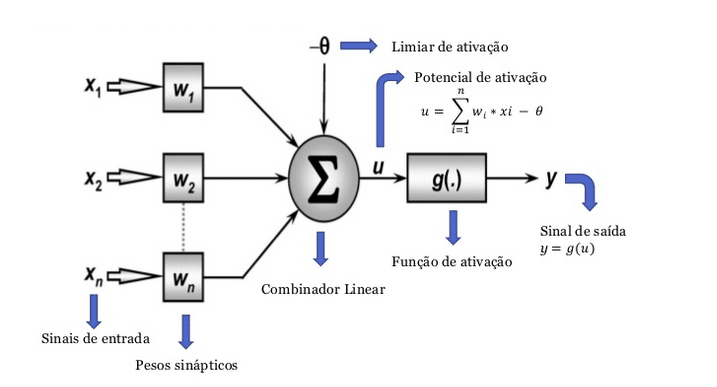

In [12]:
def initialize_parameters(n_x, n_y):
    W = np.random.randn(n_y, n_x) * 0.01  # Small random weights
    b = np.zeros((n_y, 1))  # Bias initialized to zero
    return {"W": W, "b": b}

def forward_propagation(X, parameters):
    W = parameters['W']
    b = parameters['b']
    Z = np.dot(W, X) + b # Combinador Linear + Bias(limiar de ativação)
    A = np.where(Z > 0, 1, -1)  # Activation using sign function
    return A # Sinal de saída

def update_parameters(parameters, X, Y, learning_rate):
    m = X.shape[1]  # Número de exemplos de treinamento
    W = parameters['W']
    b = parameters['b']
    for i in range(m):  # Iterar sobre cada exemplo de treinamento
        xi = X[:, [i]]  # Pegar a coluna i de X X[0] = [0, 0, 0] (3,1)
        yi = Y[:, [i]]  # Pegar a coluna i de Y Y[0] = [1, -1, -1, -1, -1, -1, -1, -1] (8,1)
        A = forward_propagation(xi, parameters)  # Previsão para o exemplo xi
        error = yi - A  # Calcula o erro como a diferença entre o desejado e o previsto
        for j in range(Y.shape[0]):  # Iterar sobre cada saída
            # Atualizar W e b para cada saída j baseado no erro
            W[j, :] = W[j, :] + learning_rate * error[j, 0] * xi.T # pega a linha inteira de W e atualiza
            b[j, 0] = b[j, 0] + learning_rate * error[j, 0] 
    parameters['W'] = W
    parameters['b'] = b
    return parameters

def nn_model(X, Y, num_iterations=100, learning_rate=0.001):
    n_x, n_y = layer_sizes(X, Y)
    parameters = initialize_parameters(n_x, n_y)
    for i in range(num_iterations):
        parameters = update_parameters(parameters, X, Y, learning_rate)
    return parameters

In [13]:
def predict(parameters, X):
    W = parameters['W']
    b = parameters['b']
    Z = np.dot(W, X) + b
    A = np.where(Z > 0, 1, -1)  # Aplica a função sinal
    
    predictions = A
    return predictions


parameters = nn_model(X, Y)
# Realizando previsões com o modelo treinado
predictions = predict(parameters,conjunto_validacao.T)

# Agora, faça a iteração e imprima os resultados
for i in range(len(predictions)):
    # Assegure-se de que estamos comparando valores escalares
    acertou = "✅ Acertou" if np.array_equal(predictions[i], respostas[i])  else "❌ Errou"
    print(f"Entrada: {conjunto_validacao[i]} | Saída Prevista: {predictions[i]} | Esperado: {respostas[i]} | {acertou}")


Entrada: [0.02471852 0.08211516 0.0462219 ] | Saída Prevista: [ 1 -1 -1 -1 -1 -1 -1 -1] | Esperado: [ 1. -1. -1. -1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [ 0.00283491 -0.04160092  0.99252032] | Saída Prevista: [-1  1 -1 -1 -1 -1 -1 -1] | Esperado: [-1.  1. -1. -1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [ 0.04407801  1.03793016 -0.03713921] | Saída Prevista: [-1 -1  1 -1 -1 -1 -1 -1] | Esperado: [-1. -1.  1. -1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [-0.06577794  1.09034865  0.98057293] | Saída Prevista: [-1 -1 -1  1 -1 -1 -1 -1] | Esperado: [-1. -1. -1.  1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [ 1.08552649 -0.0336995   0.01301374] | Saída Prevista: [-1 -1 -1 -1  1 -1 -1 -1] | Esperado: [-1. -1. -1. -1.  1. -1. -1. -1.] | ✅ Acertou
Entrada: [ 0.91073295 -0.04552059  0.91702884] | Saída Prevista: [-1 -1 -1 -1 -1  1 -1 -1] | Esperado: [-1. -1. -1. -1. -1.  1. -1. -1.] | ✅ Acertou
Entrada: [1.09687496 0.97830764 0.07166844] | Saída Prevista: [-1 -1 -1 -1 -1 -1  1 -1] | Esperado: [-1. -1. 

# Questão 2

### Perceptron MLP

In [11]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
    
        parameters['W' + str(l)] =  np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):

    Z = np.dot(W,A) + b
    cache = (A, W, b)
    
    return Z, cache

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    elif activation == "linear":  # Função de ativação linear para a camada de saída no caso de regressão
        A = Z
        activation_cache = Z
    
    cache = (linear_cache, activation_cache)
    
    return A, cache


def L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid'):
    caches = []
    A = X
    L = len(parameters) // 2                  # número de camadas na rede neural
    
    # Implementa [LINEAR -> ACTIVATION]*(L-1).
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation=hidden_activation)
        caches.append(cache)
    
    # Implementa LINEAR -> ACTIVATION na última camada.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation=output_activation)
    caches.append(cache)
          
    return AL, caches


def compute_cost(AL, Y, problema='regressao'):
    m = Y.shape[1]
    if problema == 'regressao':
        cost = (1./m) * np.sum(np.square(AL - Y)) # Custo quadrático médio (usado para regressão)
    elif problema == 'classificacao':
        cost = -(1./m) * (np.dot(Y, np.log(AL).T) + np.dot(1-Y, np.log(1-AL).T)) # Entropia cruzada binária (para problemas de classificação binária)
    cost = np.squeeze(cost)  # Garante que o custo seja um escalar (e não um array de dimensão 1)
    return cost


def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1] # número de exemplos

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "linear":
        dZ = dA
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches, hidden_activation='relu', output_activation='sigmoid', problema='regressao'):
    grads = {}
    L = len(caches)  # número de camadas
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # após esta linha, Y tem o mesmo formato que AL
    

    if problema == 'classificacao':   
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # Derivada da função de custo entropia cruzada binária
    elif problema == 'regressao':
        dAL = 2 * (AL - Y) / m # derivada do erro quadrático médio
    
    # Camada L (saída) gradientes.
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation=output_activation)
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop de l= L-2 até l=0
    for l in reversed(range(L-1)):
        # Camadas ocultas
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation=hidden_activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

import copy

def update_parameters(params, grads, learning_rate = 0.001):
   
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters



a) a função lógica XOR


In [56]:
# Definindo todas as possíveis entradas para a função XOR
x_samples = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# As saídas correspondentes para a função XOR
y_samples = np.array([0, 1, 1, 0])

# Usaremos todas as entradas para treinamento em um problema tão simples
x_train_a = x_samples
y_train_a = y_samples

# Não há necessidade de um conjunto de validação separado neste caso,
# mas se quisermos, podemos simplesmente reutilizar o conjunto de treinamento
# ou selecionar alguns dos pares de entrada para validação.
x_val_a = x_samples
y_val_a = y_samples


In [57]:
x_train_a.shape

(4, 2)

In [58]:
x_train_a.T.shape

(2, 4)

x_train_a tem 2 atributos e 4 exemplos de treinamento.

Para a função XOR, é preferível usar funções de ativação não-lineares como a função sigmoid ou ReLU em todas as camadas ocultas. A função de ativação na camada de saída depende do tipo de problema que você está tentando resolver. No caso da função XOR, como é um problema de classificação binária, você geralmente usaria a função sigmoid na camada de saída para obter uma probabilidade como saída, que você pode então arredondar para obter uma previsão de classe binária (0 ou 1).

In [59]:
# Definindo a arquitetura da rede
layers_dims_a = [x_train_a.T.shape[0], 10, 1]  # 2 neurônios na camada de entrada, 5 na camada oculta e 1 na camada de saída

# Inicializando os parâmetros
parameters_a = initialize_parameters_deep(layers_dims_a)

# Listas para armazenar custos
costs_train_a = []
costs_val_a = []

# Número de iterações de treinamento
num_iterations = 20000

# Taxa de aprendizado
learning_rate = 0.01

# Treinamento da rede
for i in range(num_iterations):
     # Propagação para frente (treinamento)
    AL_a, caches_a = L_model_forward(x_train_a.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
    
    # Cálculo do custo (treinamento)
    cost_train_a = compute_cost(AL_a, y_train_a.reshape(1, -1), problema='classificacao')
    costs_train_a.append(cost_train_a)
    
    # Propagação para trás
    grads_a = L_model_backward(AL_a, y_train_a.reshape(1, -1), caches_a, hidden_activation='relu', output_activation='sigmoid', problema='classificacao')
    
    # Atualização dos parâmetros
    parameters_a = update_parameters(parameters_a, grads_a, learning_rate)
    
    # Propagação para frente (validação)
    AL_a_val, _ = L_model_forward(x_val_a.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
    
    # Cálculo do custo (validação)
    cost_val_a = compute_cost(AL_a_val, y_val_a.reshape(1, -1), problema='classificacao')
    costs_val_a.append(cost_val_a)
    
    # Imprimir o custo a cada 1000 iterações
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train_a:.4f} - Custo de Validação: {cost_val_a:.4f}")


Iteração 0 - Custo de Treinamento: 0.6932 - Custo de Validação: 0.6932
Iteração 1000 - Custo de Treinamento: 0.6931 - Custo de Validação: 0.6931
Iteração 2000 - Custo de Treinamento: 0.6929 - Custo de Validação: 0.6929
Iteração 3000 - Custo de Treinamento: 0.6919 - Custo de Validação: 0.6919
Iteração 4000 - Custo de Treinamento: 0.6871 - Custo de Validação: 0.6871
Iteração 5000 - Custo de Treinamento: 0.6642 - Custo de Validação: 0.6642
Iteração 6000 - Custo de Treinamento: 0.5867 - Custo de Validação: 0.5865
Iteração 7000 - Custo de Treinamento: 0.4775 - Custo de Validação: 0.4774
Iteração 8000 - Custo de Treinamento: 0.4121 - Custo de Validação: 0.4120
Iteração 9000 - Custo de Treinamento: 0.3810 - Custo de Validação: 0.3810
Iteração 10000 - Custo de Treinamento: 0.3512 - Custo de Validação: 0.3511
Iteração 11000 - Custo de Treinamento: 0.2636 - Custo de Validação: 0.2635
Iteração 12000 - Custo de Treinamento: 0.1641 - Custo de Validação: 0.1640
Iteração 13000 - Custo de Treinamento:

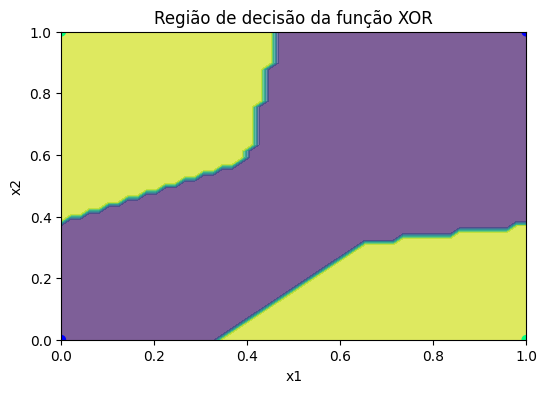

In [60]:
# Criar uma grade de pontos no intervalo de 0 a 1 (valores booleanos para XOR)
grid_x0, grid_x1 = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
grid = np.c_[grid_x0.ravel(), grid_x1.ravel()]

# Previsões para cada ponto na grade
AL_grid, _ = L_model_forward(grid.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
predictions_grid = (AL_grid > 0.5).astype(int)

# Visualizar a região de decisão
plt.figure(figsize=(6, 4))  # Aumentar o tamanho da figura
plt.contourf(grid_x0, grid_x1, predictions_grid.reshape(grid_x0.shape), alpha=0.7)
plt.scatter(x_train_a[:, 0], x_train_a[:, 1], c=y_train_a, cmap=plt.cm.winter)
plt.title("Região de decisão da função XOR")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(0, 1)  # Definir limites do eixo x
plt.ylim(0, 1)  # Definir limites do eixo y
plt.show()


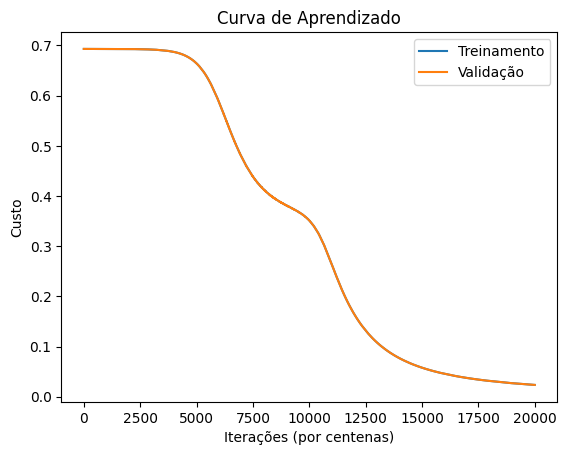

In [61]:
plt.plot(costs_train_a, label='Treinamento')
plt.plot(costs_val_a, label='Validação')
plt.ylabel('Custo')
plt.xlabel('Iterações (por centenas)')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()

b) f(x) = log10(x), onde 1 ≤ x ≤ 10


In [114]:
# Definindo a função b
def function_b(x):
    return np.log10(x)

# Gerar amostras para x (100 amostras uniformemente espaçadas entre 1 e 10)
x_samples_b = np.linspace(1, 10, 500) # 100 amostras uniformemente espaçadas entre 1 e 10
y_samples_b = function_b(x_samples_b) 

# Dividindo as amostras em conjuntos de treinamento (70%) e validação (30%)
indices_b = np.random.permutation(len(x_samples_b))
train_indices_b = indices_b[:int(0.7*len(x_samples_b))]
val_indices_b = indices_b[int(0.7*len(x_samples_b)):]

# reshape pra prevenir rank 1 array, e fazer a transposição para que cada amostra seja uma coluna
x_train_b = x_samples_b[train_indices_b].reshape(1, -1)
y_train_b = y_samples_b[train_indices_b].reshape(1, -1)
x_val_b = x_samples_b[val_indices_b].reshape(1, -1)
y_val_b = y_samples_b[val_indices_b].reshape(1, -1)



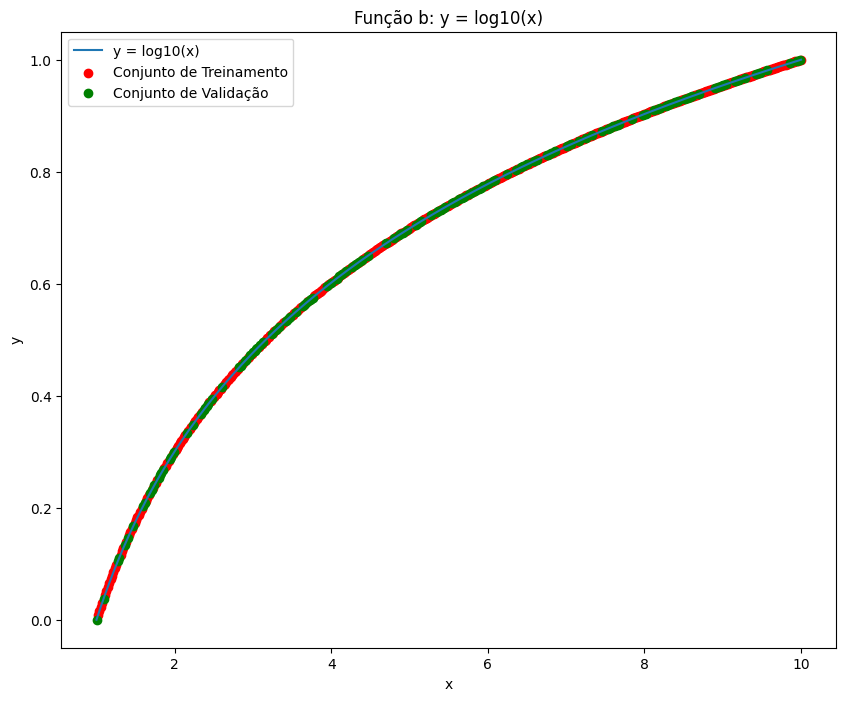

In [126]:
# plotar a função b
plt.figure(figsize=(10, 8))
plt.plot(x_samples_b, y_samples_b, label='y = log10(x)')
plt.scatter(x_train_b, y_train_b, color='r', label='Conjunto de Treinamento')
plt.scatter(x_val_b, y_val_b, color='g', label='Conjunto de Validação')
plt.title('Função b: y = log10(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


A camada de saída tem 1 neurônio, o que é típico para problemas de regressão, onde você está tentando prever um único valor contínuo.

In [123]:
# Definindo a arquitetura da rede
layer_dims_b = [x_train_b.shape[0], 300, 1]  # Exemplo: 1 neurônio na camada de entrada, 10 na oculta, 1 na saída para a função b

# Inicializando os parâmetros
parameters_b = initialize_parameters_deep(layer_dims_b)

# Lista para armazenar os custos de treinamento e validação
training_costs = []
validation_costs = []

# Treinamento do modelo
for i in range(50000):
    # Forward propagation
    AL_b, caches_b = L_model_forward(x_train_b, parameters_b, hidden_activation='relu', output_activation='linear')
    
    # Compute cost.
    cost_train = compute_cost(AL_b, y_train_b, problema='regressao')
    training_costs.append(cost_train)
    
    # Backward propagation.
    grads_b = L_model_backward(AL_b, y_train_b, caches_b, hidden_activation='relu', output_activation='linear', problema='regressao')
    
    # Update parameters.
    parameters_b = update_parameters(parameters_b, grads_b, learning_rate=0.01)
    
    # Compute validation cost.
    AL_val_b, _ = L_model_forward(x_val_b, parameters_b, hidden_activation='relu', output_activation='linear')
    cost_val = compute_cost(AL_val_b, y_val_b, problema='regressao')
    validation_costs.append(cost_val)
    
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train} - Custo de Validação: {cost_val}")


Iteração 0 - Custo de Treinamento: 0.5445757578112821 - Custo de Validação: 0.5083047625423595
Iteração 1000 - Custo de Treinamento: 0.42903412197963753 - Custo de Validação: 0.40018104975302593
Iteração 2000 - Custo de Treinamento: 0.3316913284708915 - Custo de Validação: 0.3092729147855617
Iteração 3000 - Custo de Treinamento: 0.2450352039307789 - Custo de Validação: 0.22860225731381886
Iteração 4000 - Custo de Treinamento: 0.16920075423522254 - Custo de Validação: 0.15819232293065172
Iteração 5000 - Custo de Treinamento: 0.10829078346644917 - Custo de Validação: 0.10167924990507143
Iteração 6000 - Custo de Treinamento: 0.06451238031050362 - Custo de Validação: 0.060987212008488965
Iteração 7000 - Custo de Treinamento: 0.03661460558756808 - Custo de Validação: 0.03492413886198248
Iteração 8000 - Custo de Treinamento: 0.02072240227475975 - Custo de Validação: 0.01993513524567711
Iteração 9000 - Custo de Treinamento: 0.012480105657715766 - Custo de Validação: 0.012037276388848672
Itera

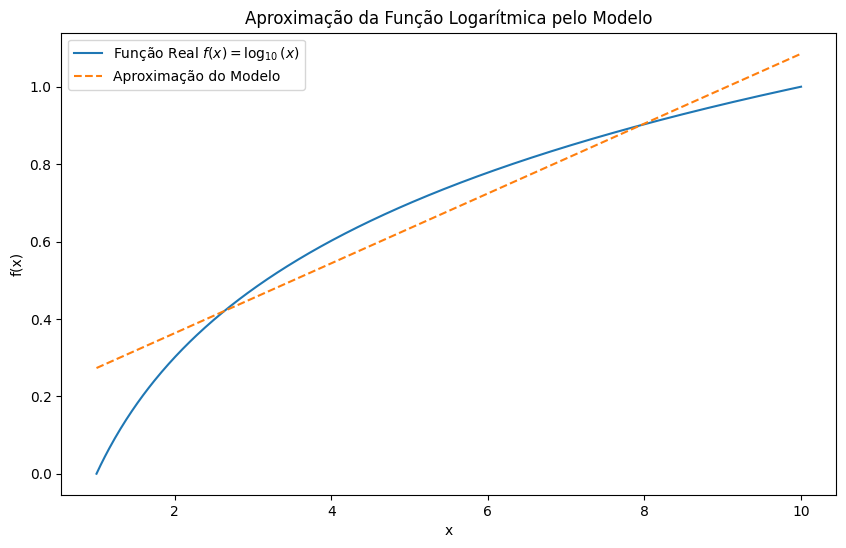

In [124]:
# Gerando dados de teste em um intervalo contínuo
x_test = np.linspace(1, 10, 500)
y_true = function_b(x_test)

# Propagação para frente para fazer previsões com o modelo treinado
x_test = x_test.reshape(1, -1)
AL_test, _ = L_model_forward(x_test, parameters_b, hidden_activation='relu', output_activation='linear')

# Plotando a função verdadeira e as previsões do modelo
plt.figure(figsize=(10, 6))
plt.plot(x_test.flatten(), y_true.flatten(), label='Função Real $f(x) = \log_{10}(x)$')
plt.plot(x_test.flatten(), AL_test.flatten(), label='Aproximação do Modelo', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Aproximação da Função Logarítmica pelo Modelo')
plt.legend()
plt.show()


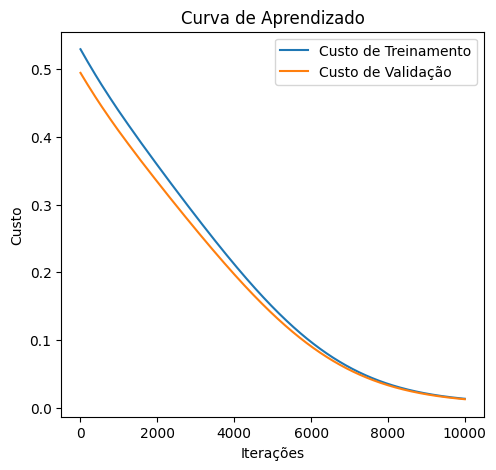

In [118]:
# Plotting the training and validation cost
plt.figure(figsize=(12, 5))

# Plot training cost
plt.subplot(1, 2, 1)
plt.plot(training_costs, label='Custo de Treinamento')
plt.plot(validation_costs, label='Custo de Validação')
plt.ylabel('Custo')
plt.xlabel('Iterações')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()

c) f(x) = 10x5+ 5x4+ 2x3– 0.5x2+ 3x + 2, onde 0 ≤ x ≤ 5


In [127]:
# Definindo a função complexa para aproximação
def function_c(x):
    return 10*x**5 + 5*x**4 + 2*x**3 - 0.5*x**2 + 3*x + 2

# Gerando dados de amostra (100 amostras uniformemente espaçadas entre 0 e 5)
x_samples_c = np.linspace(0, 5, 500)  # 200 amostras entre 0 e 5
y_samples_c = function_c(x_samples_c)

# Dividindo os dados em conjuntos de treinamento e validação
indices_c = np.random.permutation(len(x_samples_c))
train_indices_c = indices_c[:int(0.7*len(x_samples_c))]
val_indices_c = indices_c[int(0.7*len(x_samples_c)):]

x_train_c = x_samples_c[train_indices_c].reshape(1, -1)
y_train_c = y_samples_c[train_indices_c].reshape(1, -1)
x_val_c = x_samples_c[val_indices_c].reshape(1, -1)
y_val_c = y_samples_c[val_indices_c].reshape(1, -1)


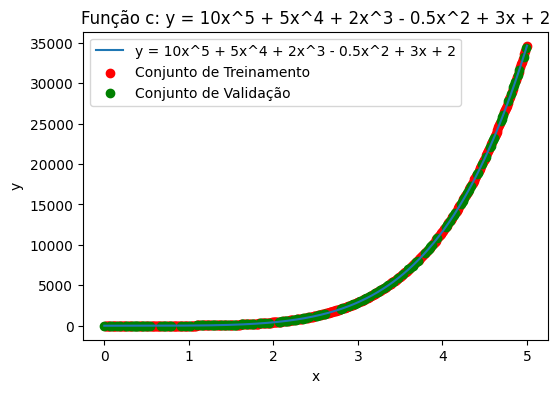

In [128]:
# Plotando a função c
plt.figure(figsize=(6, 4))
plt.plot(x_samples_c, y_samples_c, label='y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.scatter(x_train_c, y_train_c, color='r', label='Conjunto de Treinamento')
plt.scatter(x_val_c, y_val_c, color='g', label='Conjunto de Validação')
plt.title('Função c: y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Precisou de mais exemplos de treinamento para um resultado bom

In [129]:
# Definindo a arquitetura da rede para a função c
layer_dims_c = [x_train_c.shape[0], 100, 1]  # Exemplo: 1 neurônio na entrada, 20 e 10 na oculta, 1 na saída para a função c

# Inicializando os parâmetros para a função c
parameters_c = initialize_parameters_deep(layer_dims_c)

# Lista para armazenar os custos de treinamento e validação
training_costs_c = []
validation_costs_c = []

# Treinamento do modelo
for i in range(50000):
    # Forward propagation
    AL_c, caches_c = L_model_forward(x_train_c, parameters_c, hidden_activation='relu', output_activation='linear')
    
    # Compute cost.
    cost_train_c = compute_cost(AL_c, y_train_c, problema='regressao')
    training_costs_c.append(cost_train_c)
    
    # Backward propagation.
    grads_c = L_model_backward(AL_c, y_train_c, caches_c, hidden_activation='relu', output_activation='linear', problema='regressao')
    
    # Update parameters.
    parameters_c = update_parameters(parameters_c, grads_c, learning_rate=0.001)
    
    # Compute validation cost.
    AL_val_c, _ = L_model_forward(x_val_c, parameters_c, hidden_activation='relu', output_activation='linear')
    cost_val_c = compute_cost(AL_val_c, y_val_c, problema='regressao')
    validation_costs_c.append(cost_val_c)
    
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train_c} - Custo de Validação: {cost_val_c}")

Iteração 0 - Custo de Treinamento: 106564642.79113403 - Custo de Validação: 125949502.50476736
Iteração 1000 - Custo de Treinamento: 1735826.6241684505 - Custo de Validação: 2017780.5174654683
Iteração 2000 - Custo de Treinamento: 468631.6129628297 - Custo de Validação: 546906.3584953666
Iteração 3000 - Custo de Treinamento: 243104.04317351704 - Custo de Validação: 273420.6547039486
Iteração 4000 - Custo de Treinamento: 162045.69594899355 - Custo de Validação: 175681.28690191513
Iteração 5000 - Custo de Treinamento: 121879.61622719905 - Custo de Validação: 130368.88218823136
Iteração 6000 - Custo de Treinamento: 98409.70731420709 - Custo de Validação: 105887.07540012375
Iteração 7000 - Custo de Treinamento: 83641.32496658643 - Custo de Validação: 90352.75310603972
Iteração 8000 - Custo de Treinamento: 73589.2824963861 - Custo de Validação: 79774.64283833625
Iteração 9000 - Custo de Treinamento: 66327.18683702615 - Custo de Validação: 71674.86934056024
Iteração 10000 - Custo de Treiname

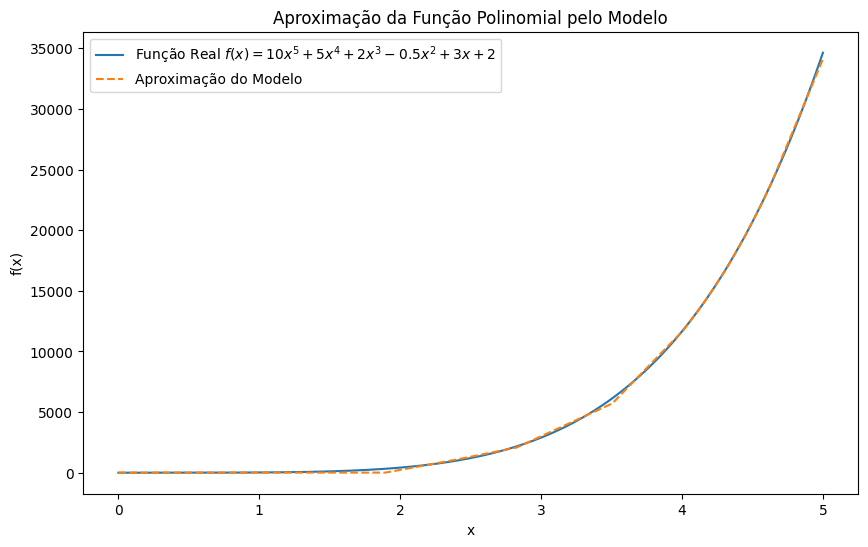

In [130]:
# Gerando dados de teste em um intervalo contínuo
x_test_c = np.linspace(0, 5, 500)
y_true_c = function_c(x_test_c)

# Propagação para frente para fazer previsões com o modelo treinado
x_test_c = x_test_c.reshape(1, -1)
AL_test_c, _ = L_model_forward(x_test_c, parameters_c, hidden_activation='relu', output_activation='linear')

# Plotando a função verdadeira e as previsões do modelo
plt.figure(figsize=(10, 6))
plt.plot(x_test_c.flatten(), y_true_c.flatten(), label='Função Real $f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2$')
plt.plot(x_test_c.flatten(), AL_test_c.flatten(), label='Aproximação do Modelo', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Aproximação da Função Polinomial pelo Modelo')
plt.legend()
plt.show()


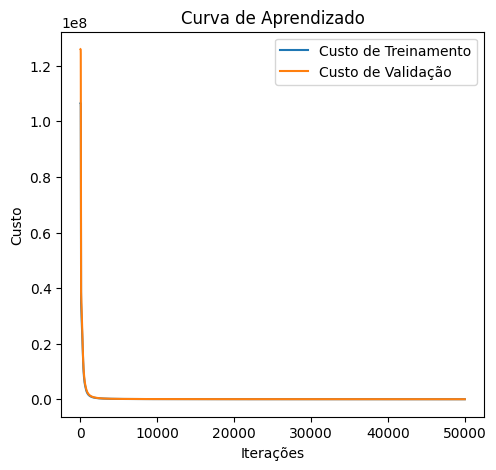

In [131]:
# Plotting the training and validation cost
plt.figure(figsize=(12, 5))

# Plot training cost
plt.subplot(1, 2, 1)
plt.plot(training_costs_c, label='Custo de Treinamento')
plt.plot(validation_costs_c, label='Custo de Validação')
plt.ylabel('Custo')
plt.xlabel('Iterações')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()


# Questão 3

In [132]:
# Definir o número de amostras por classe
samples_per_class = 100

# Inicializar listas para armazenar pontos e rótulos
points = []
labels = []

# Definir o raio do círculo e os ângulos de fronteira do losango
circle_radius = 10
diamond_angles = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4]

# Função para verificar se um ponto está dentro do losango
def is_inside_diamond(point, angles, radius):
    for angle in angles:
        if np.abs(point[0] * np.cos(angle) + point[1] * np.sin(angle)) > radius/np.sqrt(2):
            return False
    return True

# Gerar pontos e rótulos
for _ in range(samples_per_class):
    for class_label in range(1, 9):
        # Gerar coordenadas polares aleatórias dentro do círculo
        r = circle_radius * np.sqrt(np.random.rand())
        theta = 2 * np.pi * np.random.rand()
        
        # Transformar coordenadas polares em cartesianas
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        
        # Verificar se o ponto está dentro do losango
        inside_diamond = is_inside_diamond((x, y), diamond_angles, circle_radius)
        
        # Atribuir o ponto à classe correspondente
        if class_label <= 4 and inside_diamond:
            points.append((x, y))
            labels.append(class_label)
        elif class_label > 4 and not inside_diamond:
            points.append((x, y))
            labels.append(class_label)

# Converter listas em arrays numpy para facilitar a manipulação
points = np.array(points)
labels = np.array(labels)


In [134]:
# Verificar a distribuição dos pontos
points.shape, labels.shape

((389, 2), (389,))

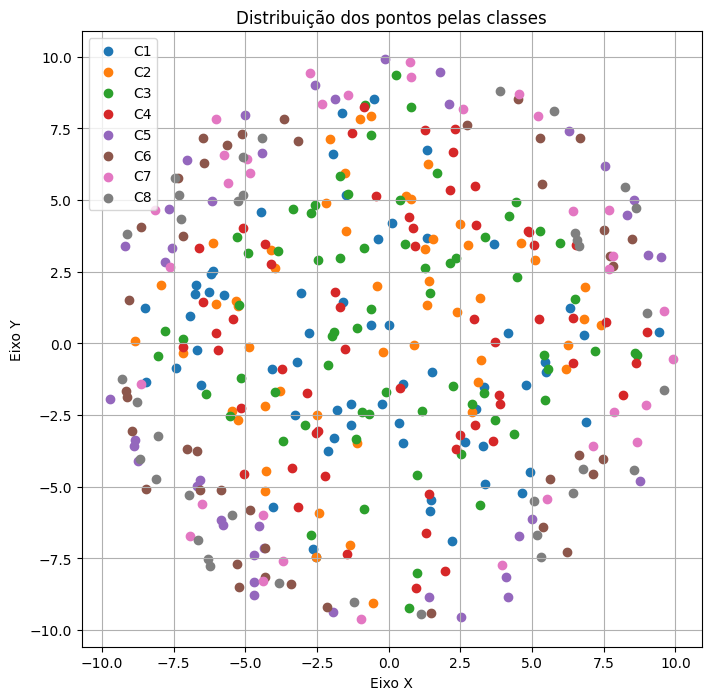

In [133]:
# Visualizar os pontos e seus rótulos
plt.figure(figsize=(8, 8))
for class_label in range(1, 9):
    plt.scatter(points[labels == class_label][:, 0], points[labels == class_label][:, 1], label=f'C{class_label}')
plt.legend()
plt.grid(True)
plt.title('Distribuição dos pontos pelas classes')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

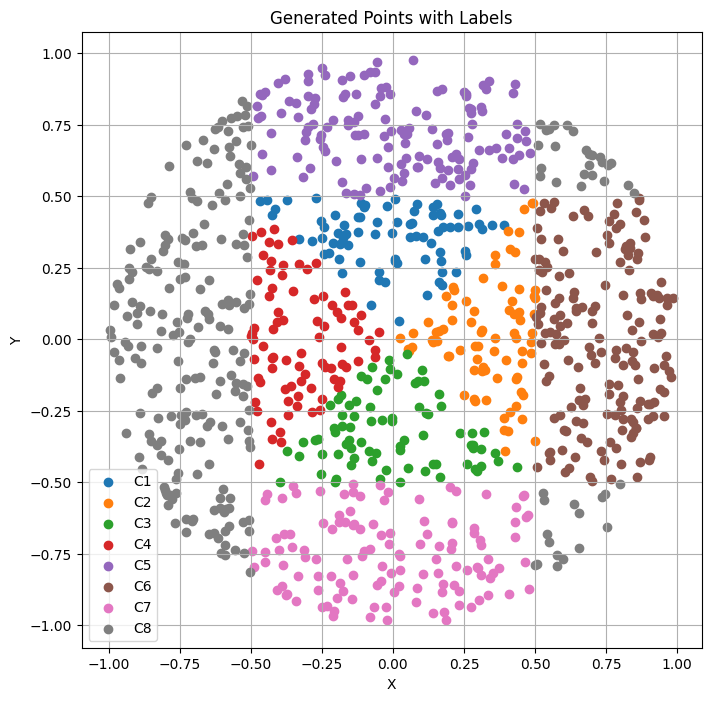

(((700, 2), (700,)), ((300, 2), (300,)))

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate random points
def generate_points(num_points, radius=1.0, losangle_width=0.5):
    points = []
    labels = []
    while len(points) < num_points:
        # Generate random point
        x, y = np.random.uniform(-radius, radius, 2)
        if x**2 + y**2 <= radius**2:  # Check if inside the circle
            points.append((x, y))
            # Determine the label based on the losangle and circle sectors
            if abs(x) < losangle_width and abs(y) < losangle_width:  # Inside losangle
                if y > x and y > -x:
                    labels.append('C1')
                elif y < x and y > -x:
                    labels.append('C2')
                elif y < x and y < -x:
                    labels.append('C3')
                else:
                    labels.append('C4')
            else:  # Outside losangle
                if y > 0 and abs(x) < losangle_width:
                    labels.append('C5')
                elif x > 0 and abs(y) < losangle_width:
                    labels.append('C6')
                elif y < 0 and abs(x) < losangle_width:
                    labels.append('C7')
                else:
                    labels.append('C8')
    return np.array(points), np.array(labels)

# Function to plot the points
def plot_points(points, labels):
    plt.figure(figsize=(8, 8))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(points[idx, 0], points[idx, 1], label=label)
    plt.legend()
    plt.title('Generated Points with Labels')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# Generate and plot points
num_points = 1000  # total number of points
points, labels = generate_points(num_points)
plot_points(points, labels)

# Split the dataset into training and validation sets (70% train, 30% validation)
num_train = int(0.7 * num_points)

indices = np.arange(num_points)
np.random.shuffle(indices)

train_indices = indices[:num_train]
valid_indices = indices[num_train:]

train_points = points[train_indices]
train_labels = labels[train_indices]

valid_points = points[valid_indices]
valid_labels = labels[valid_indices]

(train_points.shape, train_labels.shape), (valid_points.shape, valid_labels.shape)


# Questão 4

No contexto de redes neurais e previsão de séries temporais, a entrada \( X \) e a saída \( Y \) são geralmente definidas da seguinte maneira:

- \( X \) (Entradas): São as amostras de dados que você usará para fazer a previsão. No seu exemplo, você está usando uma janela deslizante de \( K \) valores anteriores para prever os próximos valores. Então, se \( K = 10 \), cada entrada \( X \) seria um vetor contendo 10 medidas de tempo consecutivas da série temporal, por exemplo, \( [x(n-9), x(n-8), ..., x(n)] \).

- \( Y \) (Saídas): São os valores que você quer prever. No exemplo dado, para cada vetor de entrada \( X \), a saída \( Y \) seria os próximos valores da série temporal. Se a tarefa é prever um passo à frente, \( Y \) seria \( x(n+1) \); se a tarefa é prever três passos à frente, \( Y \) seria um vetor contendo \( [x(n+1), x(n+2), x(n+3)] \).

Assim, para o exemplo de treinamento 1:
- \( X \) seria \( [x(0), x(1), ..., x(9)] \)
- \( Y \) seria \( [x(10), x(11), x(12)] \)

In [348]:
# Definindo a função da série temporal conforme fornecida
def time_series(n):
    return np.sin(n) + np.cos(n + np.cos(n))

# Função de treinamento
def train(X_train, Y_train, X_val, Y_val, parameters, learning_rate=0.1, n_iterations=10000):
    costs = []  # para manter o registro do custo
    cost_Val = []
    for i in range(n_iterations):
        # Passo para frente
        AL, caches = L_model_forward(X_train, parameters, hidden_activation='relu', output_activation='linear')
        
        # Calcular o custo
        cost = compute_cost(AL, Y_train, problema='regressao')
        costs.append(cost)
        
        # Retropropagação
        grads = L_model_backward(AL, Y_train, caches, hidden_activation='relu', output_activation='linear', problema='regressao')
        
        # Atualizar parâmetros
        parameters = update_parameters(parameters, grads, learning_rate)

        # Propagação pra frente validação
        AL_val, _ = L_model_forward(X_val, parameters, hidden_activation='relu', output_activation='linear')

        # Calculo do custo validação
        cost_val = compute_cost(AL_val, Y_val, problema='regressao')
        cost_Val.append(cost_val)
        
        # Imprimir o custo a cada 100 iterações
        if i % 1000 == 0:
            print(f"Iteração {i} - Custo de Treinamento: {cost} - Custo de Validação: {cost_val}")
    
    return parameters, costs

# Função para inicializar e treinar o modelo, fazer previsões e plotar
def run_model(N, K, p, learning_rate=0.1, n_iterations=10000):
    time_steps = np.arange(N)
    data = time_series(time_steps)

    # Preparando os dados de entrada (X) e saída (Y)
    X = np.array([data[i:i+K] for i in range(N-K-p)])
    Y = np.array([data[i+K:i+K+p] for i in range(N-K-p)])

    # Dados de treinamento 70%
    X_train = X[:int(0.7 * len(X))].T
    Y_train = Y[:int(0.7 * len(Y))].T

    # Dados de validação 15%
    X_val = X[int(0.7 * len(X)):int(0.85 * len(X))].T
    Y_val = Y[int(0.7 * len(Y)):int(0.85 * len(Y))].T

    # Dados de teste 15%
    X_test = X[int(0.85 * len(X)):].T
    Y_test = Y[int(0.85 * len(Y)):].T

    # Definição das dimensões das camadas
    layer_dims = [X_train.shape[0], 100, Y_train.shape[0]]

    # Inicialização dos parâmetros
    parameters = initialize_parameters_deep(layer_dims)

    # Treinamento do modelo
    trained_parameters, costs = train(X_train, Y_train, X_val, Y_val, parameters, learning_rate, n_iterations)

    # Previsões com o modelo treinado
    predictions = predict(X_test, trained_parameters)

    # Plotagem dos resultados
    plt.figure(figsize=(14, 6))
    inicio_teste = N - len(X_test.T) - p
    fim_teste = N - p

    # Dados de Treino
    plt.plot(time_steps[:inicio_teste], data[:inicio_teste], label='Dados de Treino', color='blue')
    # Dados de Teste
    plt.plot(time_steps[inicio_teste:fim_teste], data[inicio_teste:fim_teste], label='Dados de Teste', color='green')

    # Previsões
    if p == 1:
        # Precisamos ajustar o loop de plotagem para o caso de p = 1 pois não é possível traçar uma linha
        for i in range(len(X_test.T)):
            # O início das previsões é ajustado para começar após os dados de validação
            start_index = inicio_teste + i
            end_index = start_index + p
            # Garantindo que não ultrapassamos o fim dos dados e ajustando para p = 1
            if start_index < fim_teste:
                # Como p = 1, plotamos o único ponto de previsão para cada amostra de teste
                plt.scatter(time_steps[start_index], predictions[:, i], color='red', label='Previsão' if i == 0 else "", zorder=5)

        plt.title('Comparação das Previsões da Rede Neural com a Série Temporal')
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()
    else:
        for i in range(len(X_test.T)):
            start_index = inicio_teste + i
            end_index = start_index + p
            if end_index <= fim_teste:
                plt.plot(time_steps[start_index:end_index], predictions[:, i], 'r--', label='Previsão' if i == 0 else "", linewidth=2)

        plt.title('Comparação das Previsões da Rede Neural com a Série Temporal')
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

    return predictions, Y_test


### Previsão de 1 passo:

Iteração 0 - Custo de Treinamento: 0.8235268637173695 - Custo de Validação: 0.8606187688301725
Iteração 1000 - Custo de Treinamento: 0.7013252058543346 - Custo de Validação: 0.7319292559320638
Iteração 2000 - Custo de Treinamento: 0.19075986760688218 - Custo de Validação: 0.1944296918812435
Iteração 3000 - Custo de Treinamento: 0.03139605815798601 - Custo de Validação: 0.03034747790845736
Iteração 4000 - Custo de Treinamento: 0.014876198101598176 - Custo de Validação: 0.013627468250767364
Iteração 5000 - Custo de Treinamento: 0.008792312576828614 - Custo de Validação: 0.007953605059489562
Iteração 6000 - Custo de Treinamento: 0.006089322530700561 - Custo de Validação: 0.005465239738631023
Iteração 7000 - Custo de Treinamento: 0.004784796471639087 - Custo de Validação: 0.0042815309654776436
Iteração 8000 - Custo de Treinamento: 0.004067004878911994 - Custo de Validação: 0.003643953064652874
Iteração 9000 - Custo de Treinamento: 0.003618787310060632 - Custo de Validação: 0.00324799348336

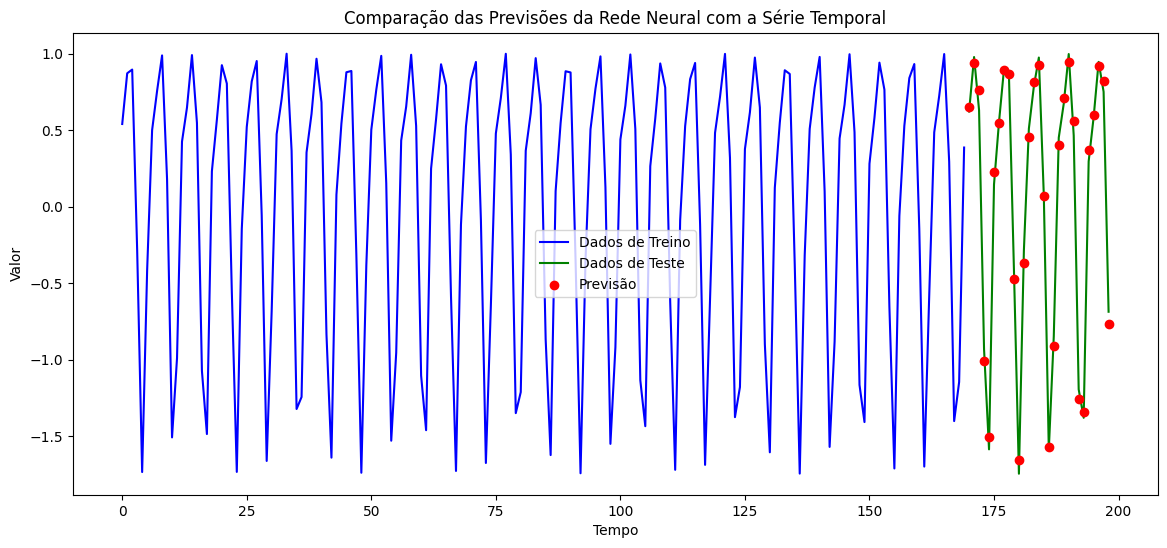

In [354]:
predictions, Y_test = run_model(N=200, K=10, p=1, learning_rate=0.1, n_iterations=10000)

### Previsão de 2 passos:

Iteração 0 - Custo de Treinamento: 1.6423718948920083 - Custo de Validação: 1.7157805969102617
Iteração 1000 - Custo de Treinamento: 1.3676823898153694 - Custo de Validação: 1.4273210340445048
Iteração 2000 - Custo de Treinamento: 0.3457492386865757 - Custo de Validação: 0.3655156544735576
Iteração 3000 - Custo de Treinamento: 0.06540914964276784 - Custo de Validação: 0.0677933284125715
Iteração 4000 - Custo de Treinamento: 0.020656623689044612 - Custo de Validação: 0.019509258397129216
Iteração 5000 - Custo de Treinamento: 0.010396485777559574 - Custo de Validação: 0.009349487939696853
Iteração 6000 - Custo de Treinamento: 0.006725726150584789 - Custo de Validação: 0.005900538469465509
Iteração 7000 - Custo de Treinamento: 0.00505138272145133 - Custo de Validação: 0.004383954101943134
Iteração 8000 - Custo de Treinamento: 0.0041139914130932775 - Custo de Validação: 0.003562383052004942
Iteração 9000 - Custo de Treinamento: 0.0034977911948214932 - Custo de Validação: 0.0030387747543723

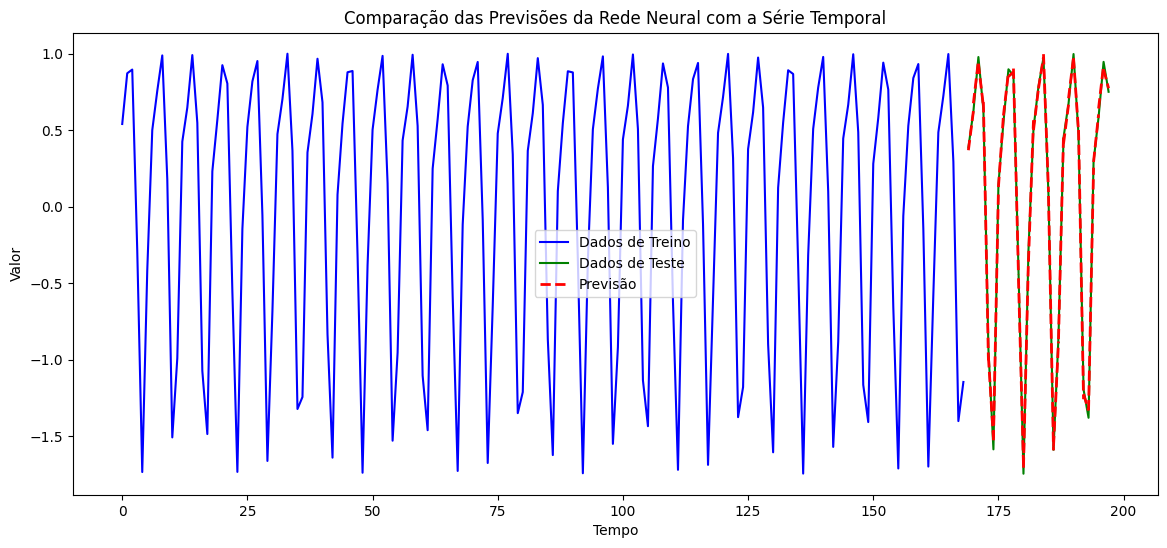

In [353]:
predictions, Y_test = run_model(N=200, K=10, p=2, learning_rate=0.1, n_iterations=10000)

### Previsão de 3 passos:

Iteração 0 - Custo de Treinamento: 2.4604683556327185 - Custo de Validação: 2.5602611674200784
Iteração 1000 - Custo de Treinamento: 1.9498696851274275 - Custo de Validação: 2.0289052125386484
Iteração 2000 - Custo de Treinamento: 0.23962362999444628 - Custo de Validação: 0.24168569128976983
Iteração 3000 - Custo de Treinamento: 0.06705826854431098 - Custo de Validação: 0.06345205462482707
Iteração 4000 - Custo de Treinamento: 0.038111246945744186 - Custo de Validação: 0.03468831469685799
Iteração 5000 - Custo de Treinamento: 0.02555896503574157 - Custo de Validação: 0.022364117442401223
Iteração 6000 - Custo de Treinamento: 0.019714706493843857 - Custo de Validação: 0.01677420748153934
Iteração 7000 - Custo de Treinamento: 0.016656228403025594 - Custo de Validação: 0.013981627031828371
Iteração 8000 - Custo de Treinamento: 0.014727737589875339 - Custo de Validação: 0.012299440038577197
Iteração 9000 - Custo de Treinamento: 0.013268947915310638 - Custo de Validação: 0.01106997105831298

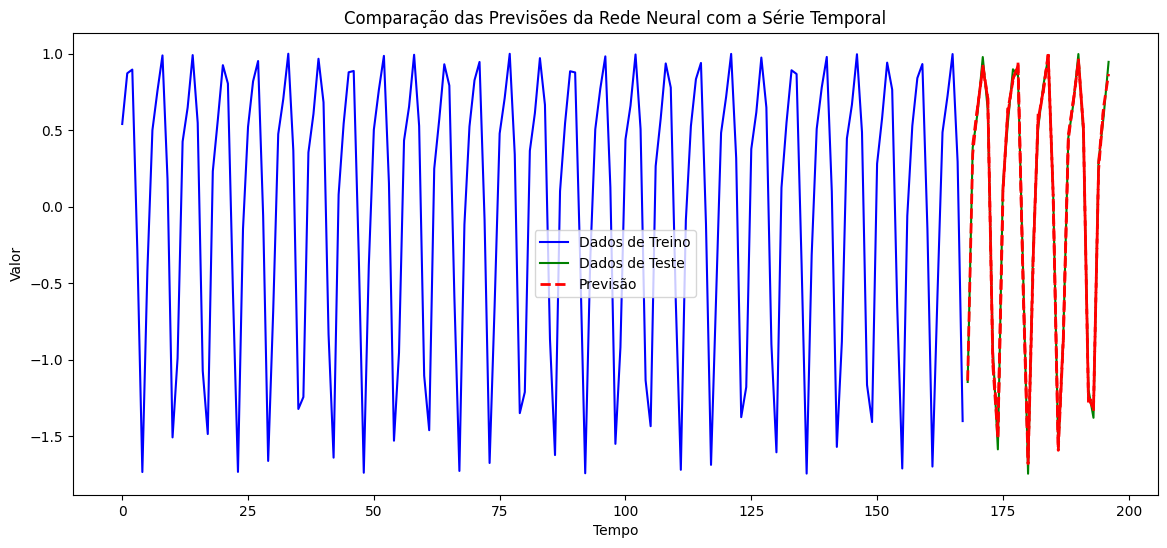

In [355]:
predictions, Y_test = run_model(N=200, K=10, p=3, learning_rate=0.1, n_iterations=10000)